In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [11]:
import os
from src.models.unet import UNet
from src.models.icnet import ICNet
from src.models.base import SegmentationModel
import src.config as global_config
from src.data_access.folds_generation import FoldsGenerator
import src.data_access.config as data_access_config
from src.evaluation.losses.dice import dice_loss, bce_dice_loss
from src.training.training_advision import TrainingAdvisor
from tensorflow.python.keras.engine.training import Model
import numpy as np
from src.utils.fs_utils import parse_json
from src.primitives.data_access import DataSetSplit
from src.data_access.data_generation import DataGenerator
import matplotlib.pyplot as plt
import time
from src.config import CLASS_TO_COLORS

In [6]:
u_net = UNet(num_classes=len(global_config.CLASS_MAPPINGS) + 1)
ic_net = ICNet(num_classes=len(global_config.CLASS_MAPPINGS) + 1)

In [43]:
def predict_from_model(model: Model, 
                       image: np.ndarray,
                       apply_colors: bool = False
                      ) -> np.ndarray:
    image = np.expand_dims(image, axis=0)
    start = time.time()
    result = model.predict_on_batch(image)
    result = np.argmax(np.squeeze(result, axis=0), axis=-1)
    print(f"INFERENCE TIME: {time.time() - start}s")
    if apply_colors:
        start = time.time()
        result = map_color(class_map=result)
        print(f"COLORING: {time.time() - start}s")
    return result


def map_color(class_map: np.ndarray) -> np.ndarray:
    return CLASS_TO_COLORS[class_map]

In [32]:
bring_colors(1)

array([255,   0,   0])

In [15]:
EXPERIMENT_RESULTS_ROOT = "/home/ppeczek/Dokumenty/YetAnotherSegmentationExperiment/resources/experiments/test_experiment_v1/ic_net/random_split_#0"
WEGIGHTS_PATH = os.path.join(
    EXPERIMENT_RESULTS_ROOT, "weights.hdf5"
)
SPLIT_JSON = os.path.join(
    EXPERIMENT_RESULTS_ROOT, "dataset.split.json"
)

In [16]:
SPLIT = parse_json(SPLIT_JSON)

In [17]:
SPLIT = DataSetSplit.from_dict(SPLIT)

In [18]:
test_generator = DataGenerator(
    examples=SPLIT.test_set.examples,
    transformation_chain=data_access_config.VALIDATION_TRANSFORMATION_CHAIN,
    batch_size=16
)

In [19]:
test_images, test_gt = test_generator[0]

In [20]:
test_images.shape

(16, 128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


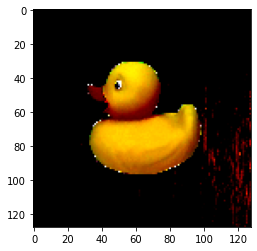

In [21]:
plt.imshow(test_images[0])

In [22]:
input_shape = global_config.MODEL_INPUT_SIZE.to_compact_form() + (3, )
model = ic_net.build_model(input_shape=input_shape)
model.load_weights(WEGIGHTS_PATH)

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
half_x_sub_sampling_conv (Conv2 (None, 64, 64, 16)   448         input[0][0]                      
__________________________________________________________________________________________________
medium_conv_0 (Conv2D)          (None, 64, 64, 64)   9280        half_x_sub_sampling_conv[0][0]   
__________________________________________________________________________________________________
medium_conv_0_bn (BatchNormaliz (None, 64, 64, 64)   256         medium_conv_0[0][0]              
__________________________________________________________________________________________________
medium_con

In [42]:
prediction = predict_from_model(model, test_images[11], apply_colors=True)

INFERENCE TIME: 0.004874467849731445s


NameError: name 'class_number' is not defined

In [35]:
prediction.shape

(128, 128, 3)

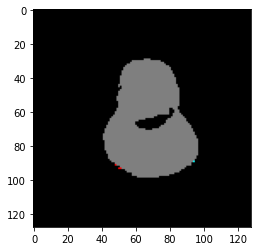

In [36]:
plt.imshow(prediction)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


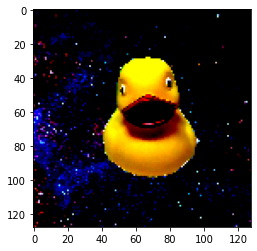

In [116]:
plt.imshow(test_images[11])